## Topic Modeling

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 

stop_words = set(stopwords.words('english'))
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [39]:
df = pd.DataFrame.from_csv('./Data/Bids.csv')

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


#### AOO

In [40]:
# Convert to list
data = df[(df.count_catogory_no_duplicate==1) & (df.Bids==True)].content.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove single word number quotes
data = [re.sub("\d+.\d*", "", sent) for sent in data]

# Remove punctation
data = [re.sub("\!", "", sent) for sent in data]

# Remove blank 
temp = [x for x in data if x != '']

data = temp
pprint(data[:2])

['notice of abandoned vehicle harrison towing & recovery maxie camp rd '
 'harrison, ar, ph: -on /harrison towing came into possession of the following '
 'described vehicle(s): year: make: ud vin # jnamergfif not claimed within '
 'days will be dismantled, destroyed or sold to the highest bidder. t. pub. / '
 '.',
 'tillage program management, christa mcauliffe center, goodwood blvd., room  '
 'baton rouge, louisiana  attendance at this pre-bid conference is mandatory '
 'and bidders must be seated prior to a.m. in order to submit a bid. the '
 'apparent low bidder must complete and deliver to csrs']


In [41]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['notice', 'of', 'abandoned', 'vehicle', 'harrison', 'towing', 'recovery', 'maxie', 'camp', 'rd', 'harrison', 'ar', 'ph', 'on', 'harrison', 'towing', 'came', 'into', 'possession', 'of', 'the', 'following', 'described', 'vehicle', 'year', 'make', 'ud', 'vin', 'jnamergfif', 'not', 'claimed', 'within', 'days', 'will', 'be', 'dismantled', 'destroyed', 'or', 'sold', 'to', 'the', 'highest', 'bidder', 'pub']]


In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['notice', 'of', 'abandoned', 'vehicle', 'harrison_towing_recovery', 'maxie_camp', 'rd', 'harrison', 'ar', 'ph', 'on', 'harrison', 'towing', 'came_into', 'possession', 'of', 'the', 'following', 'described', 'vehicle', 'year', 'make', 'ud', 'vin', 'jnamergfif', 'not', 'claimed', 'within', 'days', 'will', 'be', 'dismantled_destroyed', 'or', 'sold', 'to', 'the', 'highest', 'bidder', 'pub']


In [44]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        #texts_out.append([token for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [45]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:5])

In [46]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [47]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [48]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=1, limit=10, step=2)

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:317: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


In [49]:
coherence_values

[0.3701915659040077, nan, 0.4563296542428429, nan, nan]

#### Bids

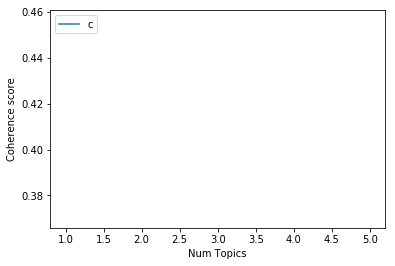

In [50]:
# Show graph
limit=10; start=1; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Auctions

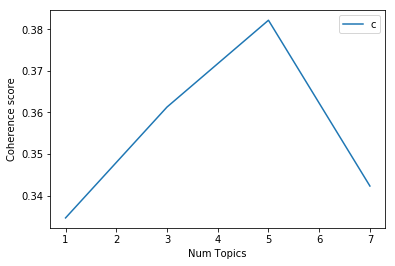

In [33]:
# Show graph
limit=10; start=1; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### AOO

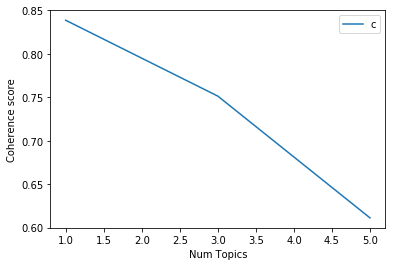

In [17]:
# Show graph
limit=10; start=1; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()